<a href="https://colab.research.google.com/github/ramyasathiya/Projectwork1/blob/main/FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from skimage.metrics import structural_similarity as ssim


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
class MRIDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.paths = [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("L")

        if self.transform:
            img = self.transform(img)

        label = 0 if "no" in img_path.lower() else 1
        return img, label


In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.ReLU(True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, True),

            nn.Flatten(),
            nn.Linear(128 * 64 * 64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
def train_ganomaly(loader, epochs=15):
    E, G, D = Encoder().to(device), Decoder().to(device), Discriminator().to(device)

    mse = nn.MSELoss()
    bce = nn.BCELoss()

    optG = torch.optim.Adam(
        list(E.parameters()) + list(G.parameters()),
        lr=0.0002, betas=(0.5, 0.999)
    )

    optD = torch.optim.Adam(
        D.parameters(),
        lr=0.00005, betas=(0.5, 0.999)
    )

    g_losses, d_losses = [], []

    for epoch in range(epochs):
        for x, _ in loader:
            x = x.to(device)
            real = torch.ones((x.size(0), 1), device=device)
            fake = torch.zeros((x.size(0), 1), device=device)

            # ---- Train Discriminator ----
            z = E(x)
            x_hat = G(z)

            optD.zero_grad()
            d_real = bce(D(x), real)
            d_fake = bce(D(x_hat.detach()), fake)
            d_loss = d_real + d_fake
            d_loss.backward()
            optD.step()

            # ---- Train Generator ----
            optG.zero_grad()
            z_hat = E(x_hat)

            recon_loss = mse(x_hat, x)
            latent_loss = mse(z_hat, z)
            adv_loss = bce(D(x_hat), real)

            g_loss = recon_loss + 0.1 * latent_loss + 0.1 * adv_loss
            g_loss.backward()
            optG.step()

        print(f"Epoch [{epoch+1}/{epochs}] | G: {g_loss.item():.4f} | D: {d_loss.item():.4f}")
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

        save_image(x_hat[:4], f"recon_epoch_{epoch+1}.png", normalize=True)

    return E, G, D, g_losses, d_losses


In [ ]:
def evaluate(E, G, loader):
    E.eval(); G.eval()
    scores, labels, ssims, mses = [], [], [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)

            z = E(x)
            x_hat = G(z)
            z_hat = E(x_hat)

            mse_val = torch.mean((x - x_hat) ** 2, dim=[1,2,3])
            latent_val = torch.mean((z - z_hat) ** 2, dim=[1,2,3])

            score = mse_val + latent_val
            scores.extend(score.cpu().numpy())
            labels.extend(y.numpy())
            mses.extend(mse_val.cpu().numpy())

            for i in range(x.size(0)):
                orig = (x[i].cpu().numpy().squeeze() + 1) / 2
                rec  = (x_hat[i].cpu().numpy().squeeze() + 1) / 2
                ssims.append(ssim(orig, rec, data_range=1.0))

    return np.array(scores), np.array(labels), np.mean(mses), np.mean(ssims)


In [ ]:
def plot_results(scores, labels, g_losses, d_losses):
    # Loss
    plt.plot(g_losses, label="Generator")
    plt.plot(d_losses, label="Discriminator")
    plt.legend()
    plt.title("GAN Loss Curves")
    plt.show()

    # Distribution
    plt.hist(scores[labels==0], bins=30, alpha=0.6, label="Normal")
    plt.hist(scores[labels==1], bins=30, alpha=0.6, label="Tumor")
    plt.legend()
    plt.title("Anomaly Score Distribution")
    plt.show()

    # ROC
    fpr, tpr, _ = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.legend()
    plt.title("ROC Curve")
    plt.show()


In [ ]:
transforms.Resize((128, 128))


Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)

In [ ]:
nn.Linear(128 * 32 * 32, 1)


Linear(in_features=131072, out_features=1, bias=True)

In [ ]:
E, G, D, g_losses, d_losses = train_ganomaly(train_loader, epochs=5)


Epoch [1/5] | G: 0.8309 | D: 0.2233
Epoch [2/5] | G: 0.7026 | D: 0.2062
Epoch [3/5] | G: 0.6007 | D: 0.3105
Epoch [4/5] | G: 1.1096 | D: 0.5949
Epoch [5/5] | G: 0.6970 | D: 0.8529


In [ ]:
epochs=15 or 20


In [ ]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)


In [ ]:
print("Using device:", device)


Using device: cpu


In [ ]:
train_ganomaly(train_loader, epochs=1)


Epoch [1/1] | G: 1.1729 | D: 1.2162


(Encoder(
   (net): Sequential(
     (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): ReLU(inplace=True)
     (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (4): ReLU(inplace=True)
     (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (7): ReLU(inplace=True)
   )
 ),
 Decoder(
   (net): Sequential(
     (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
     (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace=True)
     (6): ConvTr

Epoch [1/15] | G: 1.3818 | D: 0.1155
Epoch [2/15] | G: 0.9368 | D: 0.0321
Epoch [3/15] | G: 1.6539 | D: 0.2091
Epoch [4/15] | G: 0.4455 | D: 2.4969
Epoch [5/15] | G: 0.7852 | D: 0.0776
Epoch [6/15] | G: 0.5946 | D: 0.0613
Epoch [7/15] | G: 0.5383 | D: 0.0670
Epoch [8/15] | G: 1.3090 | D: 0.0002
Epoch [9/15] | G: 1.0972 | D: 0.8530
Epoch [10/15] | G: 0.0739 | D: 2.6744
Epoch [11/15] | G: 0.4504 | D: 0.1381
Epoch [12/15] | G: 0.3559 | D: 0.1528
Epoch [13/15] | G: 0.3397 | D: 0.3981
Epoch [14/15] | G: 0.4664 | D: 0.3656
Epoch [15/15] | G: 0.3367 | D: 0.3911


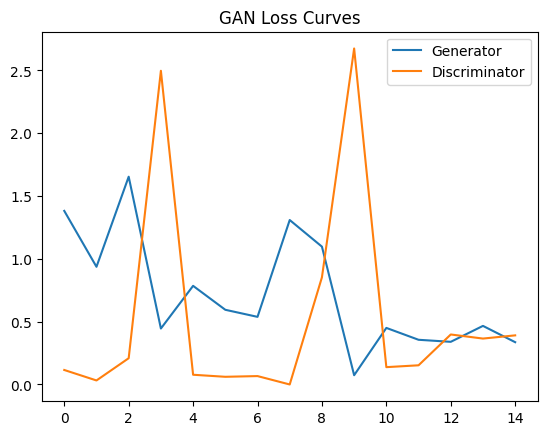

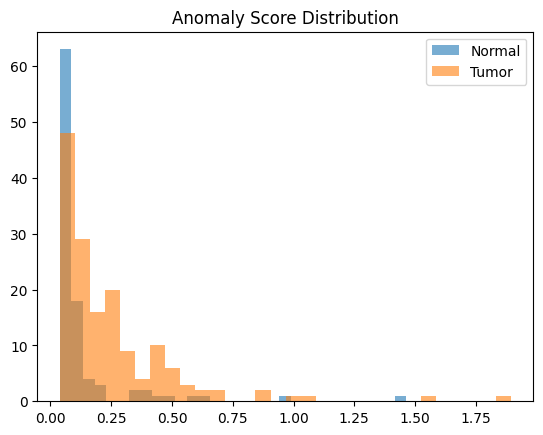

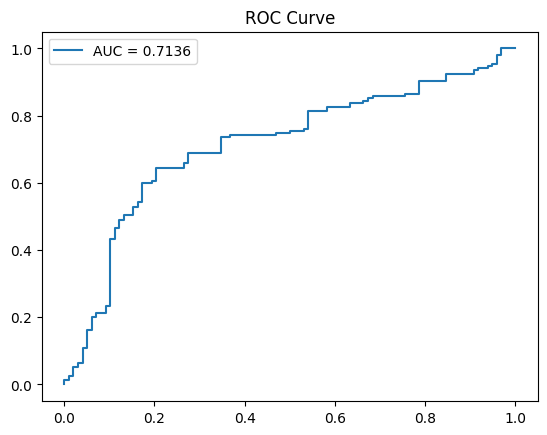

Mean MSE : 0.04316888
Mean SSIM: 0.46253618902236565


In [ ]:
if __name__ == "__main__":

    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    train_data = MRIDataset(
        r"/content/drive/MyDrive/archive (16)/no",
        transform
    )

    test_data = ConcatDataset([
        MRIDataset(
            r"/content/drive/MyDrive/archive (16)/no",
            transform
        ),
        MRIDataset(
            r"/content/drive/MyDrive/archive (16)/yes",
            transform
        )
    ])

    train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

    E, G, D, g_losses, d_losses = train_ganomaly(train_loader)

    scores, labels, mean_mse, mean_ssim = evaluate(E, G, test_loader)

    plot_results(scores, labels, g_losses, d_losses)

    print("Mean MSE :", mean_mse)
    print("Mean SSIM:", mean_ssim)
